In [1]:
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pysindy as ps

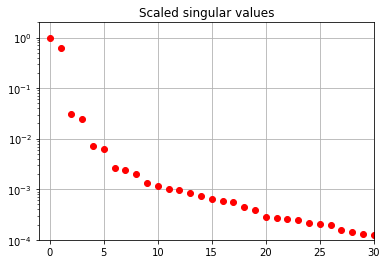

In [2]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("data/plasmaphysics_example_trajectories.txt")
t = A[:, 0]
A = A[:,1:]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

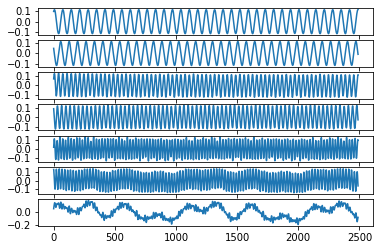

In [3]:
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i + 1)
    plt.plot(x[:, i])

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [4]:
# We need a quadratic library with particular ordering 
# for the model constraints that we use later
library_functions = [lambda x:x]
library_function_names = [lambda x:x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

# Working with Shaowu Koopman stability paper Eq 2.31
# need r(r-1) / 2 equality constraints for the antisymmetry
# and r(r-1) / 2 equality constraints for setting most of the off-diagonals to zero
# and r inequality constraints for the diagonal

num_constraints = int(r * (r + 1) / 2 + (r - 1) * (r - 2) / 2)
num_coefficients = int(r ** 2)
constraint_zeros = np.zeros(num_constraints)
constraint_matrix = np.zeros((num_constraints, num_coefficients))

# Define the constraint matrix
q = r
for i in range(r):
    # Constraint that the diagonal must be negative real numbers since asking that these satisfy < 0
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    # Constraint of anti-symmetry
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

# Constraint of zero off-diagonal terms except nearest off-diagonal (see Eq 2.31)
q = r
for i in range(r):
    counter = 1
    for j in range(i + 2, r):
        constraint_matrix[q + int(r * (r - 1) / 2), i * r + j] = 1.0
        counter += 1
        q += 1
        
print(constraint_matrix[-1, :])

threshold = 0.0
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-5,
    max_iter=100,
    tol=1e-6,
    equality_constraints=True,
    inequality_constraints=True,
    constraint_separation_index=r,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [5]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)

model.fit(x_train, t=t_train)
model.print()

(x0)' = 0.091 x1
(x1)' = -0.091 x0
(x2)' = 0.179 x3
(x3)' = -0.179 x2 + -0.001 x3
(x4)' = 0.263 x5
(x5)' = -0.263 x4 + 0.003 x6
(x6)' = -0.003 x5


In [6]:
Xi = model.coefficients()
model.get_feature_names()

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

In [7]:
print(Xi, Xi.shape, np.sort(np.real(np.linalg.eigvals(Xi))))
print(sindy_opt.coef_full_, np.sort(np.real(np.linalg.eigvals(sindy_opt.coef_full_))))

[[ 5.69998010e-07  9.06430921e-02  6.18586498e-12 -4.33631098e-12
  -3.41772849e-12 -1.58221788e-12 -1.25799828e-11]
 [-9.06430921e-02 -3.87710562e-05 -2.27201428e-04 -4.02986035e-14
  -9.66811466e-12 -2.38241101e-14 -6.48768423e-12]
 [-1.50663272e-11  2.27201432e-04  1.88175857e-06  1.78784289e-01
  -2.12368849e-12 -6.55043553e-12  5.12873646e-12]
 [ 4.37986915e-12  8.45566158e-14 -1.78784289e-01 -5.20269490e-04
  -1.97163406e-04 -8.13969278e-15 -5.17879804e-12]
 [ 9.13985135e-12  1.93025972e-11 -4.23333823e-12  1.97163414e-04
   1.41341381e-06  2.62760876e-01  2.42686903e-13]
 [ 1.64528781e-12  3.81375937e-14  6.59098705e-12  1.63339060e-14
  -2.62760876e-01 -3.35134110e-04  2.96465534e-03]
 [ 3.52862829e-11  1.29754962e-11  5.96702152e-12  1.03526010e-11
   2.48402147e-12 -2.96465534e-03  1.29716640e-06]] (7, 7) [-2.59192982e-04 -2.59192982e-04 -1.66860536e-04 -1.66860536e-04
 -1.91012330e-05 -1.91012330e-05  1.29718123e-06]
[[ 1.04851521e-04  9.04202578e-02  1.07716718e-04 -1.10324

In [8]:
Xi[abs(Xi)<1e-5] = 0.0
print(Xi, np.real(np.linalg.eigvals(Xi)))

[[ 0.00000000e+00  9.06430921e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.06430921e-02 -3.87710562e-05 -2.27201428e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.27201432e-04  0.00000000e+00  1.78784289e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.78784289e-01 -5.20269490e-04
  -1.97163406e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.97163414e-04
   0.00000000e+00  2.62760876e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.62760876e-01 -3.35134110e-04  2.96465534e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.96465534e-03  0.00000000e+00]] [-1.93862325e-05 -1.93862325e-05 -2.60133860e-04 -2.60133860e-04
 -1.67567236e-04 -1.67567236e-04  1.50570804e-29]


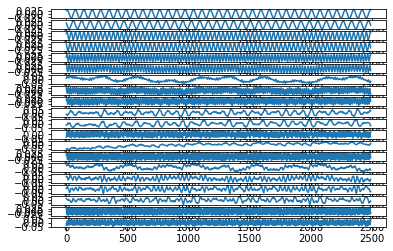

In [9]:
# Okay let's make sure it works at high numbers of modes:
r = 20
poly_order = 2
threshold = 0.05
tfrac = 0.7  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i + 1)
    plt.plot(x[:, i])

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

threshold = 0.0
sindy_opt = ps.StableLinearSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-10,
    max_iter=10,
    tol=1e-12,
    verbose=True,
#     verbose_cvxpy=True,
    #equality_constraints=True,
    #inequality_constraints=True,
    #constraint_separation_index=r,
    #constraint_lhs=constraint_matrix,
    #constraint_rhs=constraint_zeros,
)

In [10]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)

model.fit(x_train, t=t_train)
model.print()
Xi = model.coefficients()


 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 4.4977e-02 ... 1.0296e+03 ... 0.0000e+00 ... 4.4977e-02
         1 ... 4.4977e-02 ... 2.9246e-17 ... 0.0000e+00 ... 4.4977e-02
         2 ... 4.4977e-02 ... 2.9261e-17 ... 0.0000e+00 ... 4.4977e-02
         3 ... 4.4977e-02 ... 2.9258e-17 ... 0.0000e+00 ... 4.4977e-02
         4 ... 4.4977e-02 ... 2.9236e-17 ... 0.0000e+00 ... 4.4977e-02
         5 ... 4.4977e-02 ... 2.9266e-17 ... 0.0000e+00 ... 4.4977e-02
         6 ... 4.4977e-02 ... 2.9304e-17 ... 0.0000e+00 ... 4.4977e-02
         7 ... 4.4977e-02 ... 2.9273e-17 ... 0.0000e+00 ... 4.4977e-02
         8 ... 4.4977e-02 ... 2.9260e-17 ... 0.0000e+00 ... 4.4977e-02
         9 ... 4.4977e-02 ... 2.9250e-17 ... 0.0000e+00 ... 4.4977e-02
(x0)' = 0.090 x1 + 0.010 x4 + 0.003 x5 + -0.001 x11 + -0.001 x13
(x1)' = -0.091 x0 + 0.008 x4 + -0.010 x5 + 0.002 x6 + 0.002 x11 + 0.001 x13 + -0.001 x14 + 0.001 x15 + -0.001 x16
(x2)

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stable_linear_sr3.py:395: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10 iterations.
  ConvergenceWarning,


In [11]:
print(np.linalg.eigh(sindy_opt.coef_.T))
print(np.linalg.eigh(sindy_opt.coef_full_.T))
print(np.linalg.norm(sindy_opt.coef_full_ - sindy_opt.coef_))

sindy_opt.eigs_history[-1, :]

(array([-0.50668605, -0.42428874, -0.34795698, -0.27170637, -0.19109878,
       -0.17657787, -0.10226271, -0.09039777, -0.0118794 , -0.00429673,
        0.00312441,  0.02059682,  0.088669  ,  0.09076735,  0.17439843,
        0.17781343,  0.2696261 ,  0.36500094,  0.43830056,  0.49666619]), array([[ 1.42552310e-04, -4.88449906e-04, -2.28324777e-05,
        -1.62594484e-03, -6.28556530e-03,  6.51655422e-04,
         2.88831613e-03, -7.07948031e-01,  1.72018539e-03,
         4.51824752e-03, -2.43442444e-03, -7.30115501e-03,
        -1.62727677e-01,  6.86057473e-01,  2.21097370e-05,
        -2.01700830e-02, -3.33484526e-02,  8.64786648e-04,
         9.71974776e-04,  5.17479782e-05],
       [-1.29421562e-04,  2.02967518e-03,  1.24565521e-03,
        -4.66419374e-02,  1.71666766e-02,  1.33533955e-04,
        -1.46666735e-03,  7.04960989e-01,  6.77994095e-04,
         1.57624268e-03, -1.40159351e-03,  3.39300223e-03,
        -1.63442391e-01,  6.88043244e-01, -5.70959699e-04,
        -1.990890

array([0.00299356, 0.00473987, 0.01509424, 0.01742666, 0.08772332,
       0.09057988, 0.09128867, 0.0919433 , 0.16014819, 0.16676079,
       0.18063598, 0.18199043, 0.26945375, 0.27027281, 0.35482038,
       0.35587649, 0.43906206, 0.43993746, 0.49741671, 0.50140734])

In [12]:
print(np.sort(np.linalg.eigvals(sindy_opt.coef_history[-1, :])))
print(np.sort(np.linalg.eigvals(sindy_opt.coef_history[0, :])))

[-1.04512851e-03-0.00363718j -1.04512851e-03+0.00363718j
 -2.38555817e-05-0.26985413j -2.38555817e-05+0.26985413j
 -1.88313704e-05-0.35532859j -1.88313704e-05+0.35532859j
 -6.26362912e-06-0.18109305j -6.26362912e-06+0.18109305j
 -9.99996544e-11-0.09098057j -9.99996544e-11+0.09098057j
 -9.99908212e-11-0.49931352j -9.99908212e-11+0.49931352j
 -9.99868938e-11-0.43948305j -9.99868938e-11+0.43948305j
 -9.99868348e-11-0.08958841j -9.99868348e-11+0.08958841j
 -9.99866509e-11-0.16340873j -9.99866509e-11+0.16340873j
 -9.99723178e-11-0.01620064j -9.99723178e-11+0.01620064j]
[-1.04512851e-03-0.00363718j -1.04512851e-03+0.00363718j
 -2.38555817e-05-0.26985413j -2.38555817e-05+0.26985413j
 -1.88313704e-05-0.35532859j -1.88313704e-05+0.35532859j
 -6.26362912e-06-0.18109305j -6.26362912e-06+0.18109305j
  1.89704660e-06-0.09098057j  1.89704660e-06+0.09098057j
  5.12452064e-05-0.49931352j  5.12452064e-05+0.49931352j
  7.31750133e-05-0.43948305j  7.31750133e-05+0.43948305j
  8.11783337e-05-0.16340873j  

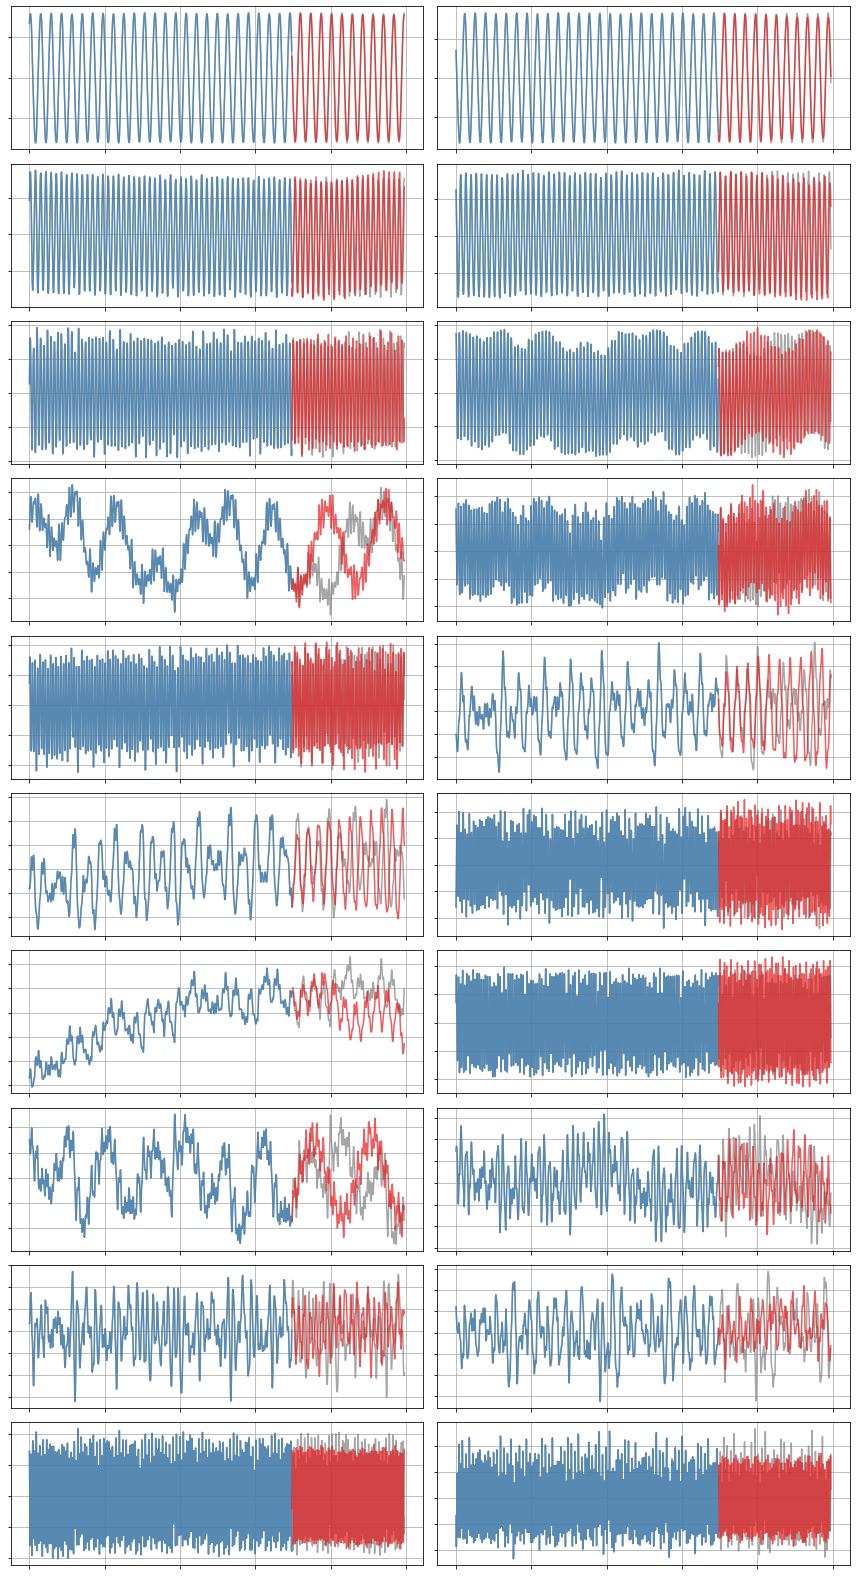

In [13]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, 
                            figsize=(12, 2 * (n_rows + 1)), 
                            sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), 
                label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), 
                label="Predicted (test)", **kws)

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)

### Looks awesome!!